In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


In [20]:
# CSV'den veri yükleme
df = pd.read_csv(r"C:\Users\sakir\OneDrive\Masaüstü\career\akbank\globalaihub2\data\processed\fraud_detection2.csv")  # dosya adını güncelleyin

# Eksik değerleri kontrol et
print(df.isnull().sum())

# Gerekli sütunları seç
df = df.dropna(subset=["transaction_speed"])  # NaN olan satırları çıkar

# Kategorik verileri sayısal veriye çevir
df_encoded = pd.get_dummies(df, columns=["category", "gender", "state", "job"])

# Etiket sütununu ayrı tut
labels = df["is_fraud"].values


category                0
amt                     0
gender                  0
city                    0
state                   0
city_pop                0
job                     0
is_fraud                0
hour                    0
age                     0
is_night_transaction    0
transaction_speed       1
distance_to_merchant    0
dtype: int64


In [21]:
features = df_encoded.drop(columns=["is_fraud", "city"])  # city çok ayrık, model için anlamlı olmayabilir
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)


One-hot encoding sonrası özellik sayısı arttıysa, PCA ile boyut indirgeme sonrası analiz yapmak çok daha iyi olur.

In [22]:
from sklearn.decomposition import PCA

# Boyutları 10'a düşürelim
pca = PCA(n_components=10)
X_reduced = pca.fit_transform(X_scaled)


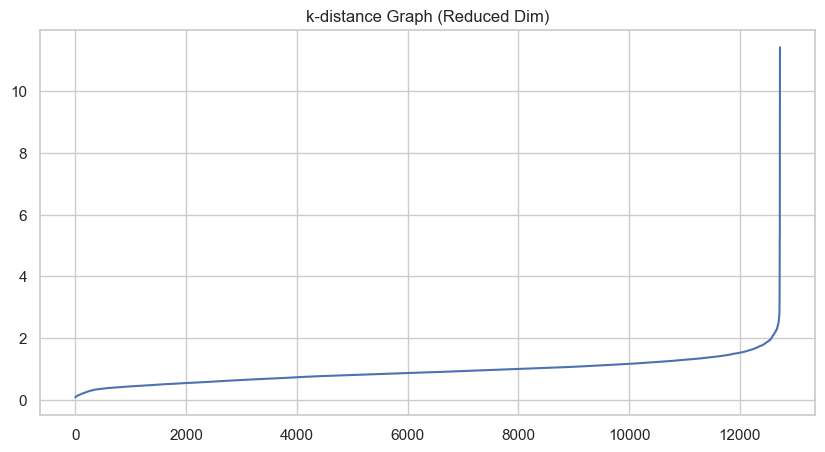

In [23]:
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_reduced)
distances, indices = neighbors_fit.kneighbors(X_reduced)

distances = np.sort(distances[:, 4], axis=0)

plt.figure(figsize=(10, 5))
plt.plot(distances)
plt.title("k-distance Graph (Reduced Dim)")
plt.grid(True)
plt.show()


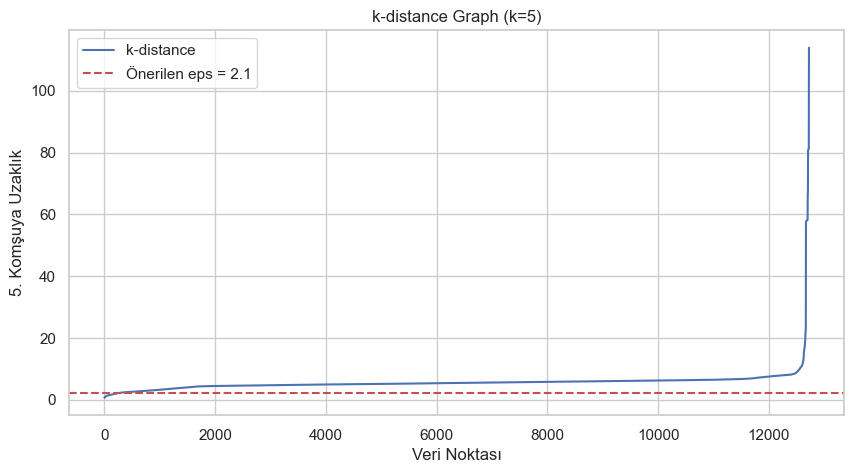

In [24]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

distances = np.sort(distances[:, 4], axis=0)

plt.figure(figsize=(10, 5))
plt.plot(distances, label='k-distance')
plt.axhline(y=2.1, color='r', linestyle='--', label='Önerilen eps = 2.1')  # Örneğin
plt.title("k-distance Graph (k=5)")
plt.xlabel("Veri Noktası")
plt.ylabel("5. Komşuya Uzaklık")
plt.legend()
plt.grid(True)
plt.show()


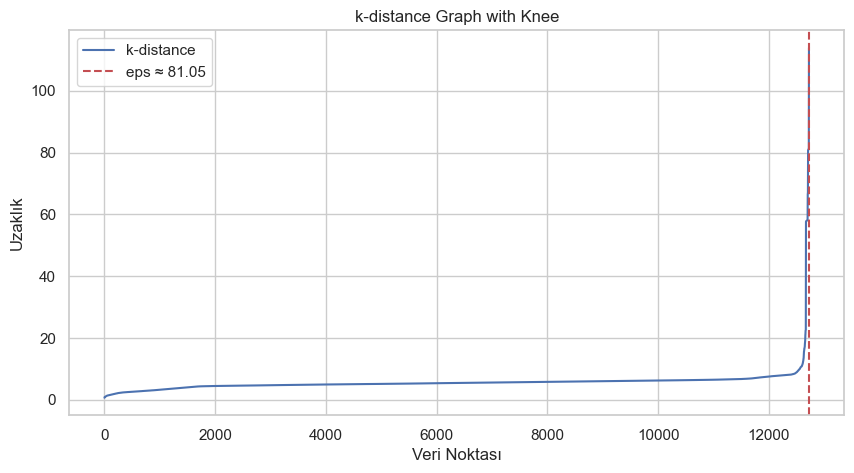

Optimal eps değeri: 81.04580764644876


In [25]:
!pip install kneed

from kneed import KneeLocator

kneedle = KneeLocator(range(len(distances)), distances, curve="convex", direction="increasing")
optimal_eps = distances[kneedle.knee]

plt.figure(figsize=(10, 5))
plt.plot(distances, label='k-distance')
plt.axvline(kneedle.knee, color='r', linestyle='--', label=f'eps ≈ {optimal_eps:.2f}')
plt.title("k-distance Graph with Knee")
plt.xlabel("Veri Noktası")
plt.ylabel("Uzaklık")
plt.legend()
plt.grid(True)
plt.show()

print(f"Optimal eps değeri: {optimal_eps}")


 1. Neden eps = 81.05 gibi büyük çıktı?
 
k-distance grafiğinde distances değerleri ölçeklenmemiş ya da dengesiz değişkenlerden etkilenmiş olabilir. Şu nedenlerle bu olur:

Ölçekleme öncesi çalıştıysan: age, distance_to_merchant, transaction_speed gibi özellikler çok farklı ölçeklerde olabilir. Bu DBSCAN'in uzaklık hesaplamasını bozar.

Kategorik değişkenleri one-hot encode ederken çok fazla sütun oluştuysa, öklidyen mesafe bu yüksek boyutlardan dolayı büyür.

KneeLocator, bazen grafikteki lokal minimumları değil, uzak bir noktayı "knee" olarak yanlış tanır.

In [26]:
dbscan = DBSCAN(eps=2.1, min_samples=5)
dbscan.fit(X_scaled)

df['cluster'] = dbscan.labels_


In [27]:
# Cluster dağılımı
print(df['cluster'].value_counts())

# Fraud ile ilişkisini incele
cross_tab = pd.crosstab(df['cluster'], df['is_fraud'])
print(cross_tab)

# Anomalileri listele
anomalies = df[df['cluster'] == -1]
print(f"Anomali Sayısı: {anomalies.shape[0]}")
print(anomalies[['amt', 'is_fraud', 'transaction_speed']].head())


cluster
-1     12337
 10        9
 9         8
 39        8
 12        8
       ...  
 45        5
 48        5
 52        5
 55        5
 61        5
Name: count, Length: 71, dtype: int64
is_fraud     0     1
cluster             
-1        6274  6063
 0           1     5
 1           0     5
 2           0     7
 3           0     5
...        ...   ...
 65          3     2
 66          4     1
 67          1     4
 68          0     5
 69          0     5

[71 rows x 2 columns]
Anomali Sayısı: 12337
      amt  is_fraud  transaction_speed
1    6.94         1         11798126.0
2   41.96         0         -2066814.0
3  992.69         1          8805055.0
4   21.37         1        -25745360.0
6  671.44         1         -8423657.0


C:\Users\sakir\AppData\Local\Temp\ipykernel_20900\1203982623.py:10: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


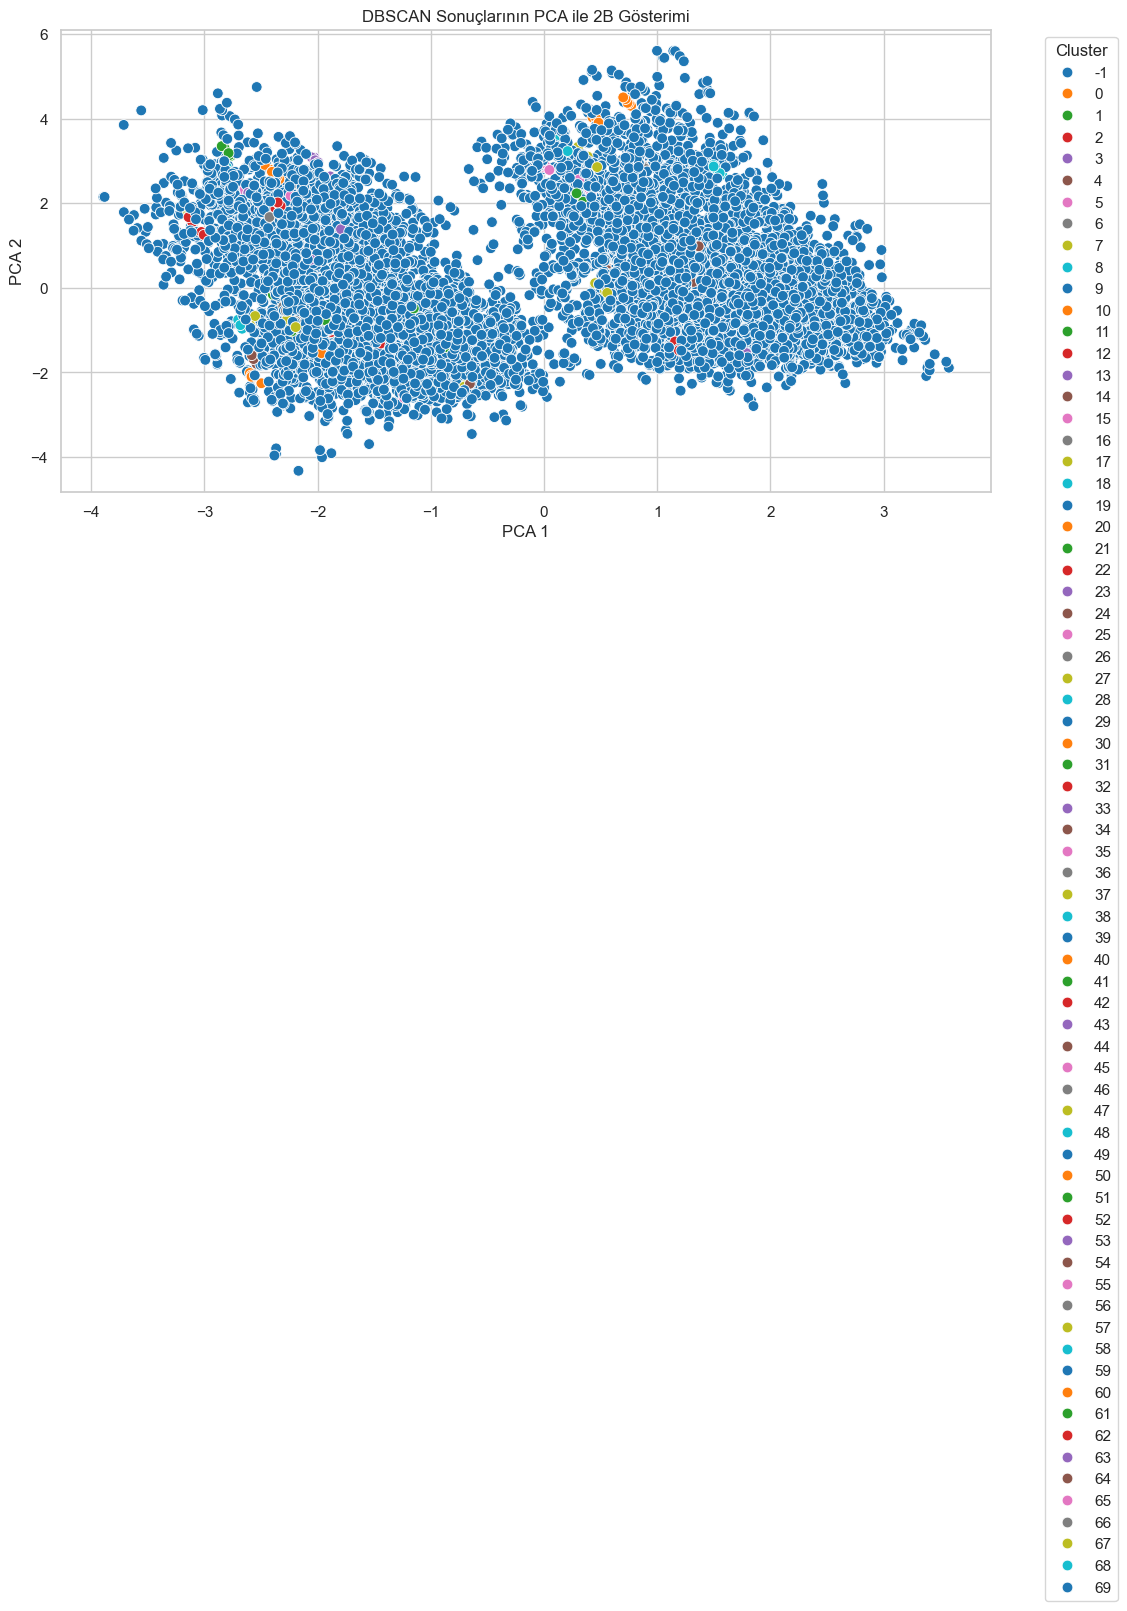

In [28]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['cluster'], palette='tab10', s=60)
plt.title("DBSCAN Sonuçlarının PCA ile 2B Gösterimi")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [29]:
from sklearn.metrics import classification_report

# Sadece anomaly (-1) olanları fraud olarak tahmin kabul et
y_pred = (df['cluster'] == -1).astype(int)
print(classification_report(labels, y_pred, target_names=["Not Fraud", "Fraud"]))


              precision    recall  f1-score   support

   Not Fraud       0.23      0.01      0.03      6362
       Fraud       0.49      0.95      0.65      6363

    accuracy                           0.48     12725
   macro avg       0.36      0.48      0.34     12725
weighted avg       0.36      0.48      0.34     12725



In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

In [35]:
df = pd.read_csv(r'C:\Users\sakir\OneDrive\Masaüstü\career\akbank\globalaihub2\data\processed\fraud_detection2.csv')
df.head()

,category,amt,gender,city,state,city_pop,job,is_fraud,hour,age,is_night_transaction,transaction_speed,distance_to_merchant
0,grocery_net,36.68,M,Birmingham,AL,493806,Musician,0,9,39,0,NaN,80.874467
1,travel,6.94,M,Boulder,MT,1939,Patent attorney,1,22,53,1,11798126.0,52.287253
2,gas_transport,41.96,M,Cleveland,AL,3996,Aid worker,0,0,43,1,-2066814.0,25.509482
3,shopping_net,992.69,M,Powell,TN,25459,"Teacher, special educational needs",1,22,51,1,8805055.0,67.055703
4,health_fitness,21.37,M,Saint James City,FL,3776,Sport and exercise psychologist,1,22,43,1,-25745360.0,78.931562


In [36]:
df.isnull().sum()

category                0
amt                     0
gender                  0
city                    0
state                   0
city_pop                0
job                     0
is_fraud                0
hour                    0
age                     0
is_night_transaction    0
transaction_speed       1
distance_to_merchant    0
dtype: int64

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12726 entries, 0 to 12725
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   category              12726 non-null  object 
 1   amt                   12726 non-null  float64
 2   gender                12726 non-null  object 
 3   city                  12726 non-null  object 
 4   state                 12726 non-null  object 
 5   city_pop              12726 non-null  int64  
 6   job                   12726 non-null  object 
 7   is_fraud              12726 non-null  int64  
 8   hour                  12726 non-null  int64  
 9   age                   12726 non-null  int64  
 10  is_night_transaction  12726 non-null  int64  
 11  transaction_speed     12725 non-null  float64
 12  distance_to_merchant  12726 non-null  float64
dtypes: float64(3), int64(5), object(5)
memory usage: 1.3+ MB


In [50]:
df_scaled[:5]

array([[-0.70642753,  1.2598256 , -0.5122393 , -0.48934507,         nan,
         0.19748223, -0.21713786, -0.31594068,  6.25660534, -0.44961516,
        -0.21192776, -0.25307474, -0.24989562, -0.30667718, -0.22107684,
        -0.22992763, -0.42087338, -0.33397324, -0.15324489,  1.05377785],
       [-0.78637032, -0.28836053,  1.02993181,  0.28228748,  0.62285076,
        -0.79143072, -0.21713786, -0.31594068, -0.15983108, -0.44961516,
        -0.21192776, -0.25307474, -0.24989562, -0.30667718, -0.22107684,
        -0.22992763, -0.42087338, -0.33397324,  6.52550318,  1.05377785],
       [-0.69223459, -0.28188598, -1.57989622, -0.26887863, -0.10908531,
        -1.71774994, -0.21713786,  3.16515115, -0.15983108, -0.44961516,
        -0.21192776, -0.25307474, -0.24989562, -0.30667718, -0.22107684,
        -0.22992763, -0.42087338, -0.33397324, -0.15324489,  1.05377785],
       [ 1.863381  , -0.21432967,  1.02993181,  0.17205426,  0.46484527,
        -0.28054807, -0.21713786, -0.31594068, -


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


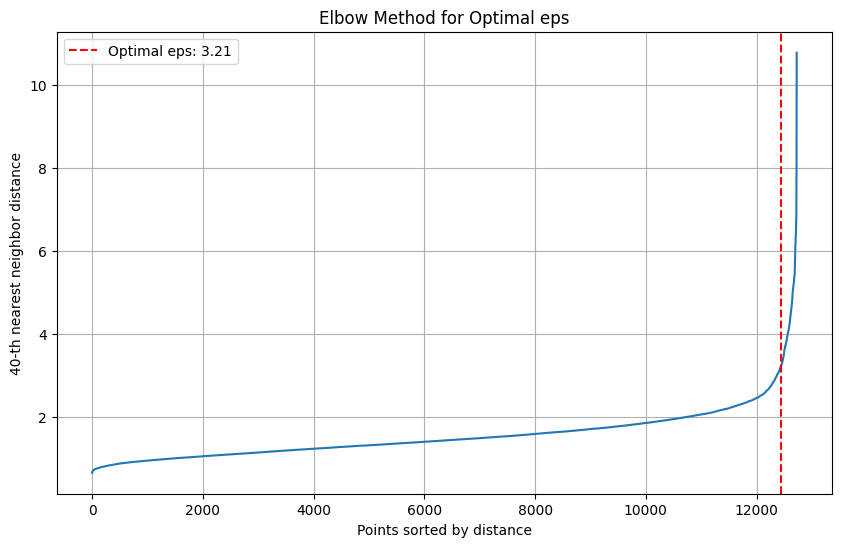

In [53]:
%pip install kneed

from kneed import KneeLocator

def find_optimal_eps(df_scaled, min_samples=40):
    # Remove rows with NaN values
    df_scaled_no_nan = df_scaled[~np.isnan(df_scaled).any(axis=1)]
    
    neighbors = NearestNeighbors(n_neighbors=min_samples).fit(df_scaled_no_nan)
    distances, _ = neighbors.kneighbors(df_scaled_no_nan)

    distances = np.sort(distances[:, min_samples - 1])

    kneedle = KneeLocator(range(len(distances)), distances, curve='convex', direction='increasing')
    optimal_eps = distances[kneedle.elbow]

    plt.figure(figsize=(10, 6))
    plt.plot(distances)
    plt.axvline(x=kneedle.elbow, color='r', linestyle='--', label=f'Optimal eps: {optimal_eps:.2f}')
    plt.xlabel('Points sorted by distance')
    plt.ylabel(f'{min_samples}-th nearest neighbor distance')
    plt.title('Elbow Method for Optimal eps')
    plt.legend()
    plt.grid(True)
    plt.show()

    return optimal_eps

optimal_eps = find_optimal_eps(df_scaled)

Optimal eps Değeri (3.21):

Bu değer, DBSCAN algoritmasında kullanılacak komşuluk yarıçapını temsil eder.
Bu yarıçap içinde en az min_samples=40 veri noktası bulunuyorsa, bir küme oluşturulacaktır.

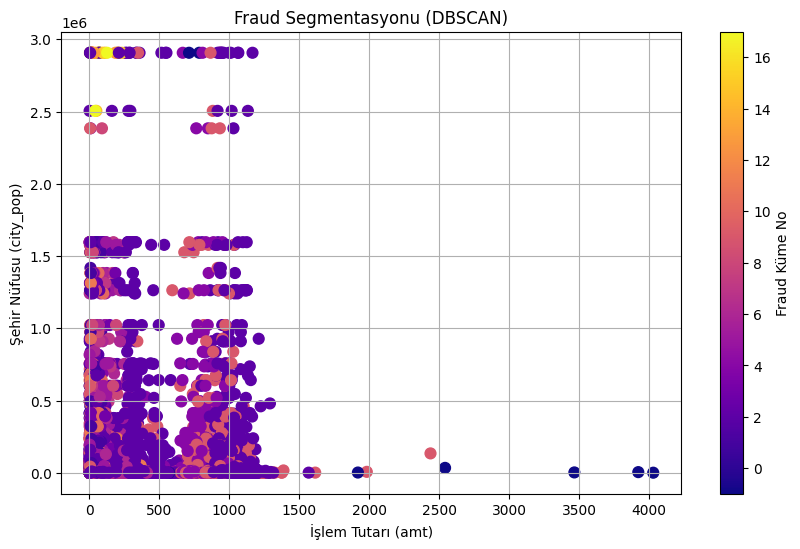

In [55]:
dbscan = DBSCAN(eps=optimal_eps, min_samples=3)
# eps noktasının birbirine olan uzaklığıdır(metre cinsinden gibi düşün). 
# min_samples ise bir küme oluşturmak için gereken minimum nokta sayısıdır.

# NaN içeren satırları çıkar
df_no_nan = df.dropna().copy()
df_scaled_no_nan = df_scaled[~np.isnan(df_scaled).any(axis=1)]

# DBSCAN ile kümeleme (fraud analizi için)
df_no_nan['fraud_cluster'] = dbscan.fit_predict(df_scaled_no_nan)

plt.figure(figsize=(10, 6))
plt.scatter(df_no_nan['amt'], df_no_nan['city_pop'], c=df_no_nan['fraud_cluster'], cmap='plasma', s=60)
plt.xlabel("İşlem Tutarı (amt)")
plt.ylabel("Şehir Nüfusu (city_pop)")
plt.title("Fraud Segmentasyonu (DBSCAN)")
plt.grid(True)
plt.colorbar(label='Fraud Küme No')
plt.show()

In [ ]:
outliers = df[df['cluster'] == -1]
print("Aykırı Veriler:", len(outliers))
print(outliers[['customer_id', 'total_orders', 'total_spent', 'avg_order_value']])
# Aykırı verileri inceleyelim
# öğrenirken 11 tane müşteriyi hesaba almadık.
# Bu müşteriler, diğerlerinden çok farklı olan ve kümeleme algoritması tarafından aykırı olarak kabul edilen müşterilerdir.


In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import classification_report
from kneed import KneeLocator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def run_dbscan_pipeline(df_raw, min_samples=5, pca_components=10, plot=True):
    df = df_raw.copy()

    # Drop NaN'ler ve encode
    df = df.dropna(subset=["transaction_speed"])
    df_encoded = pd.get_dummies(df, columns=["category", "gender", "state", "job"], drop_first=True)

    # Etiketleri ayır
    labels = df_encoded["is_fraud"].values
    df_encoded = df_encoded.drop(columns=["is_fraud", "city"])  # city fazla ayrık olabilir

    # Ölçekleme
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_encoded)

    # PCA ile boyut indir
    pca = PCA(n_components=pca_components)
    X_reduced = pca.fit_transform(X_scaled)

    # k-distance
    neighbors = NearestNeighbors(n_neighbors=min_samples)
    neighbors_fit = neighbors.fit(X_reduced)
    distances, _ = neighbors_fit.kneighbors(X_reduced)
    distances = np.sort(distances[:, min_samples - 1], axis=0)

    # Knee ile eps seçimi
    kneedle = KneeLocator(range(len(distances)), distances, curve="convex", direction="increasing")
    eps = distances[kneedle.knee]

    if plot:
        plt.figure(figsize=(10, 5))
        plt.plot(distances)
        plt.axvline(x=kneedle.knee, color='r', linestyle='--', label=f"eps ≈ {eps:.2f}")
        plt.title("k-distance Graph")
        plt.xlabel("Veri Noktası")
        plt.ylabel(f"{min_samples}. Komşuya Uzaklık")
        plt.legend()
        plt.grid(True)
        plt.show()

    # DBSCAN eğitimi
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan.fit(X_reduced)
    clusters = dbscan.labels_

    # Sonuçları dataframe'e ekle
    df_results = df.copy()
    df_results["cluster"] = clusters

    # Görselleştirme
    if plot:
        pca_vis = PCA(n_components=2).fit_transform(X_scaled)
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=pca_vis[:, 0], y=pca_vis[:, 1], hue=clusters, palette="tab10", s=60)
        plt.title("DBSCAN PCA Görselleştirme")
        plt.xlabel("PCA 1")
        plt.ylabel("PCA 2")
        plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

    # Anomali (cluster == -1) istatistiği
    y_pred = (clusters == -1).astype(int)
    print(classification_report(labels, y_pred, target_names=["Not Fraud", "Fraud"]))

    print(f"Toplam {np.sum(clusters == -1)} anomali tespit edildi (cluster = -1).")
    print(f"Otomatik seçilen eps değeri: {eps:.2f}")

    return df_results, eps


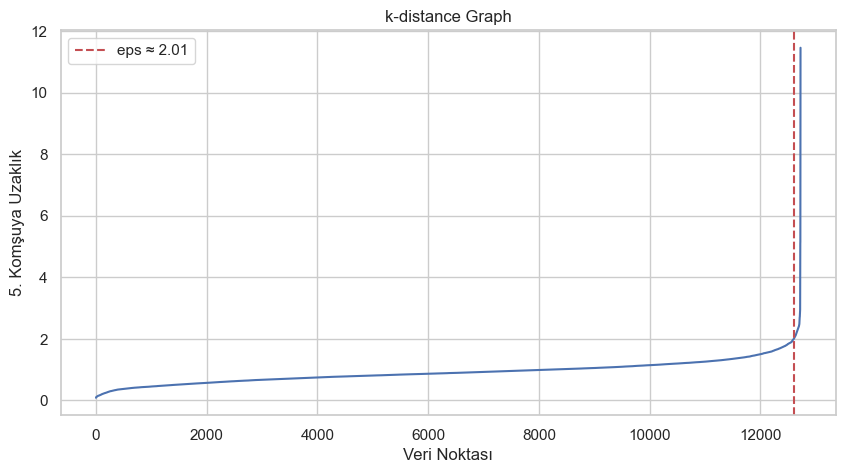

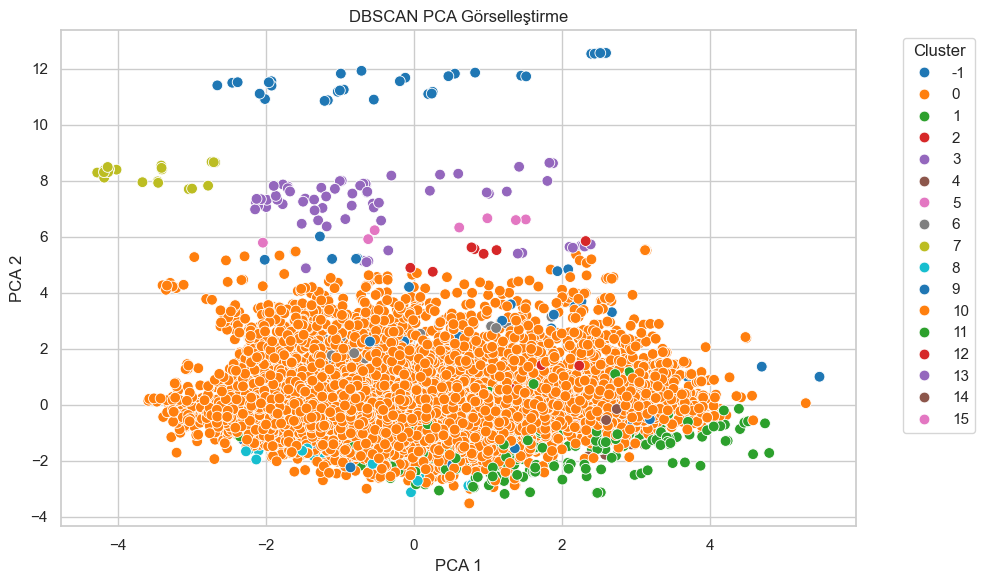

              precision    recall  f1-score   support

   Not Fraud       0.50      1.00      0.67      6362
       Fraud       0.67      0.01      0.01      6363

    accuracy                           0.50     12725
   macro avg       0.58      0.50      0.34     12725
weighted avg       0.58      0.50      0.34     12725

Toplam 60 anomali tespit edildi (cluster = -1).
Otomatik seçilen eps değeri: 2.01


In [31]:
# Projeyi çalıştır
df = pd.read_csv(r"C:\Users\sakir\OneDrive\Masaüstü\career\akbank\globalaihub2\data\processed\fraud_detection2.csv")  # kendi dosya yolunla değiştir
results, selected_eps = run_dbscan_pipeline(df)
